In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Upload Excel file to Colab
from google.colab import files
print("\nPlease upload your dataset file: AC-Ni-bio-reactor-dataset.xlsx")
uploaded = files.upload()

# Verify upload
if 'AC-Ni-bio-reactor-dataset.xlsx' in uploaded:
    print("Dataset uploaded successfully!")
else:
    print("Dataset not found. Please upload the Excel file.")


Please upload your dataset file: AC-Ni-bio-reactor-dataset.xlsx


Saving AC-Ni-bio-reactor-dataset.xlsx to AC-Ni-bio-reactor-dataset (1).xlsx
Dataset not found. Please upload the Excel file.


In [ ]:
def parse_reactor_data(df):
    """Extract and clean reactor data with proper headers"""
    headers = df.iloc[0].values
    data = df.iloc[1:].reset_index(drop=True)
    data.columns = headers

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    return data

# Load all reactor sheets
reactors = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
reactor_data = {}

print("\nReactor data...")
for reactor in reactors:
    df = pd.read_excel("AC-Ni-bio-reactor-dataset.xlsx", sheet_name=reactor)
    reactor_data[reactor] = parse_reactor_data(df)
    print(f"  {reactor}: {reactor_data[reactor].shape}")

# Load auxiliary data
print("\nOther data...")
od_data = pd.read_excel("AC-Ni-bio-reactor-dataset.xlsx", sheet_name='OD', header=1).iloc[1:].reset_index(drop=True)
nh4_data = pd.read_excel("AC-Ni-bio-reactor-dataset.xlsx", sheet_name='NH4', header=1).iloc[1:].reset_index(drop=True)
ph_data = pd.read_excel("AC-Ni-bio-reactor-dataset.xlsx", sheet_name='pH', header=1).iloc[1:].reset_index(drop=True)

# Convert to numeric
for df in [od_data, nh4_data, ph_data]:
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("  OD data loaded:", od_data.shape)
print("  NH4 data loaded:", nh4_data.shape)
print("  pH data loaded:", ph_data.shape)


Reactor data...
  R1: (47, 26)
  R2: (47, 26)
  R3: (47, 26)
  R4: (47, 26)
  R5: (47, 26)
  R6: (47, 26)

Auxiliary measurements...
  OD data loaded: (46, 43)
  NH4 data loaded: (46, 8)
  pH data loaded: (49, 8)


In [ ]:
print("FEATURE ENGINEERING")

master_data = []

for reactor_name in reactors:
    df_reactor = reactor_data[reactor_name]

    # Determine reactor characteristics
    if reactor_name in ['R1', 'R2']:
        reactor_type = 0  # Control
        ni_concentration = 0
        reactor_label = 'Control'
    elif reactor_name in ['R3', 'R4']:
        reactor_type = 1  # Low Ni
        ni_concentration = 0.01
        reactor_label = 'Low Ni'
    else:  # R5, R6
        reactor_type = 2  # High Ni
        ni_concentration = 5.0
        reactor_label = 'High Ni'

    # Extract features for each time point
    for idx, row in df_reactor.iterrows():
        if pd.notna(row['Time (days)']):
            day = row['Time (days)']

            # Determine column name for auxiliary data
            if reactor_name in ['R1', 'R2']:
                aux_col = reactor_name + ' AC'
            else:
                ni_level = '0.01%' if reactor_name in ['R3', 'R4'] else '5%'
                aux_col = reactor_name + f' AC-Ni {ni_level}'

            # Get OD, pH, NH4 values
            od_val = od_data[od_data['Day'] == day][aux_col].values
            od_value = od_val[0] if len(od_val) > 0 and pd.notna(od_val[0]) else np.nan

            ph_val = ph_data[ph_data['Day'] == day][aux_col].values
            ph_value = ph_val[0] if len(ph_val) > 0 and pd.notna(ph_val[0]) else np.nan

            nh4_val = nh4_data[nh4_data['Day'] == day][aux_col].values
            nh4_value = nh4_val[0] if len(nh4_val) > 0 and pd.notna(nh4_val[0]) else np.nan

            # Create feature vector
            data_point = {
                'Reactor': reactor_name,
                'ReactorType': reactor_type,
                'ReactorLabel': reactor_label,
                'Ni_Concentration': ni_concentration,
                'Day': day,
                'C1_mg_L': row.get('C1 (mg/L)', np.nan),
                'C2_mg_L': row.get('C2 (mg/L)', np.nan),
                'C1_e_recovery': row.get('C1 e- recovery', np.nan),
                'C2_e_recovery': row.get('C2 e- recovery', np.nan),
                'C1_cumulative_e_recovery': row.get('C1 Over time e-recovery', np.nan),
                'C2_cumulative_e_recovery': row.get('C2 Over time e-recovery', np.nan),
                'OD': od_value,
                'pH': ph_value,
                'NH4_mg_L': nh4_value,
            }

            master_data.append(data_point)

df_master = pd.DataFrame(master_data)

print(f"\n Master dataset created: {df_master.shape}")
print(f"  Total samples: {len(df_master)}")
print(f"  Features: {df_master.shape[1]}")
print(f"\nReactor type distribution:")
print(df_master['ReactorLabel'].value_counts())

FEATURE ENGINEERING

 Master dataset created: (282, 14)
  Total samples: 282
  Features: 14

Reactor type distribution:
ReactorLabel
Control    94
Low Ni     94
High Ni    94
Name: count, dtype: int64


In [ ]:
# df_master

In [ ]:
# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=df_master)

EXPLORATORY DATA ANALYSIS

1. MISSING VALUES
NH4_mg_L                    93.617021
pH                          68.085106
OD                          59.574468
C2_mg_L                     57.446809
C2_cumulative_e_recovery    57.446809
C2_e_recovery               57.446809
C1_cumulative_e_recovery    57.092199
C1_mg_L                     55.319149
C1_e_recovery               55.319149
dtype: float64

2. DESCRIPTIVE STATISTICS
       C2_e_recovery      C2_mg_L     C1_mg_L          OD         pH
count     120.000000   120.000000  126.000000  114.000000  90.000000
mean        0.087574   661.110120   11.733333    0.193781   6.867111
std         0.088757  1106.592425   37.250654    0.113978   0.195559
min         0.000000     0.000000    0.000000    0.006000   6.310000
25%         0.006587    13.665128    0.000000    0.128250   6.772500
50%         0.064132    97.305981    0.000000    0.193000   6.830000
75%         0.123741   426.676280    0.000000    0.270750   6.897500
max         0.27962

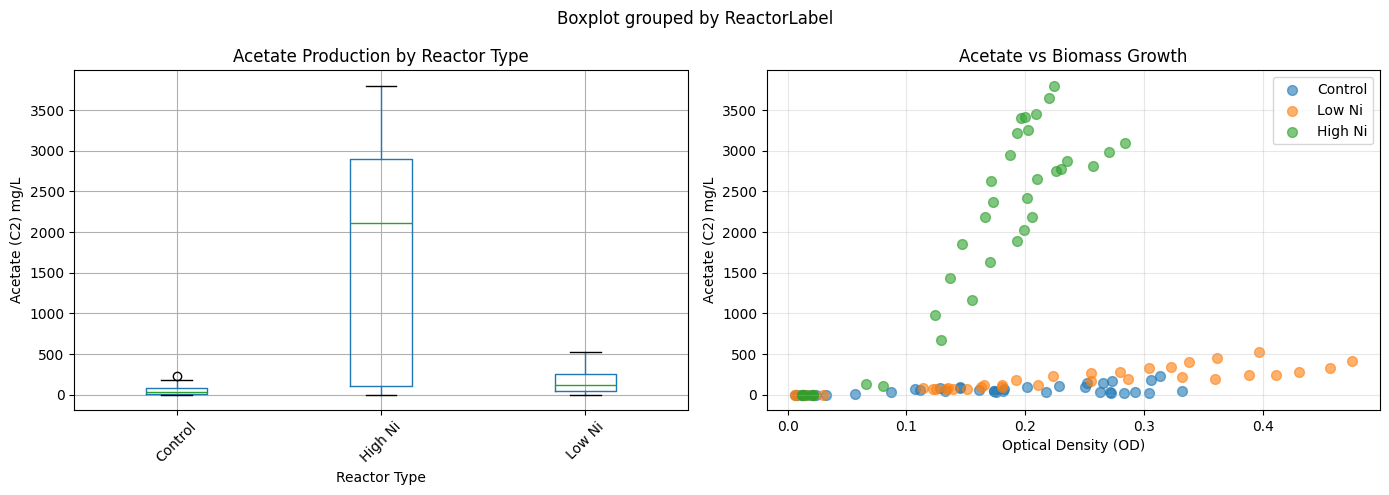


 Visualization saved: eda_acetate_analysis.png


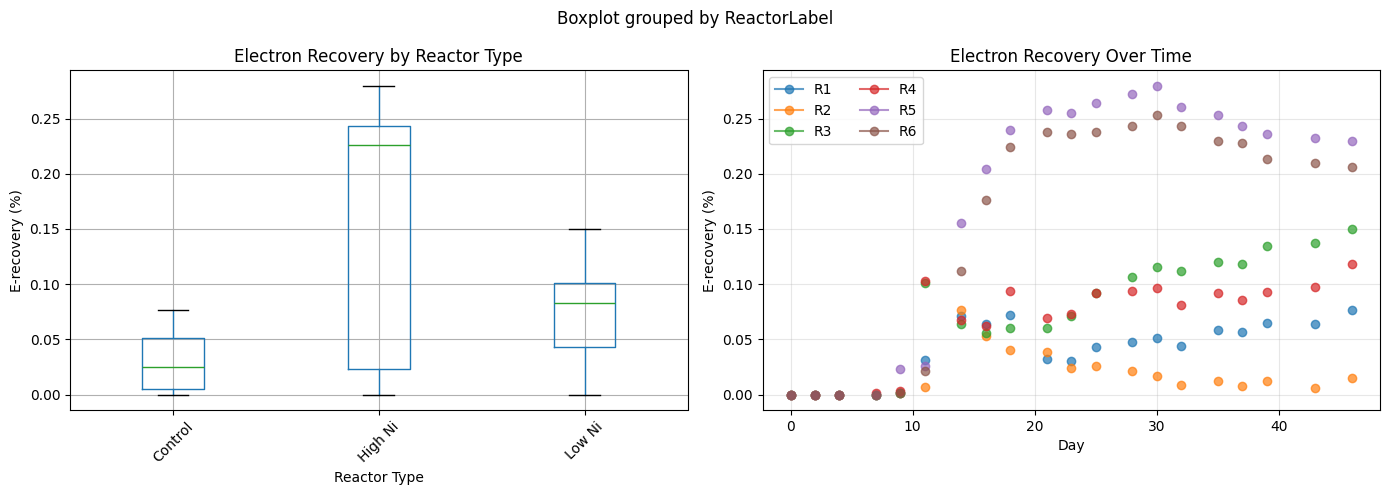

In [ ]:
print("EXPLORATORY DATA ANALYSIS")

# Missing values analysis
print("\n1. MISSING VALUES")
missing_pct = (df_master.isnull().sum() / len(df_master) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

# Basic statistics
print("\n2. DESCRIPTIVE STATISTICS")
numeric_features = ['C2_e_recovery', 'C2_mg_L', 'C1_mg_L', 'OD', 'pH']
print(df_master[numeric_features].describe())

# Visualization 1: Acetate Production by Reactor Type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df_master.boxplot(column='C2_mg_L', by='ReactorLabel', ax=axes[0])
axes[0].set_title('Acetate Production by Reactor Type')
axes[0].set_xlabel('Reactor Type')
axes[0].set_ylabel('Acetate (C2) mg/L')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Scatter plot: Acetate vs OD
for label in df_master['ReactorLabel'].unique():
    subset = df_master[df_master['ReactorLabel'] == label]
    axes[1].scatter(subset['OD'], subset['C2_mg_L'], label=label, alpha=0.6, s=50)
axes[1].set_xlabel('Optical Density (OD)')
axes[1].set_ylabel('Acetate (C2) mg/L')
axes[1].set_title('Acetate vs Biomass Growth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_acetate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: eda_acetate_analysis.png")

# Visualization 2: Electron Recovery Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Electron recovery distribution
df_master.boxplot(column='C2_e_recovery', by='ReactorLabel', ax=axes[0])
axes[0].set_title('Electron Recovery by Reactor Type')
axes[0].set_xlabel('Reactor Type')
axes[0].set_ylabel('E-recovery (%)')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Time series of electron recovery
for reactor in reactors:
    subset = df_master[df_master['Reactor'] == reactor]
    axes[1].plot(subset['Day'], subset['C2_e_recovery'], marker='o', label=reactor, alpha=0.7)
axes[1].set_xlabel('Day')
axes[1].set_ylabel('E-recovery (%)')
axes[1].set_title('Electron Recovery Over Time')
axes[1].legend(loc='best', ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_erecovery_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
print("DATA PREPROCESSING")

# Select complete cases (rows with no missing values in key features)
ml_features = ['C2_mg_L', 'C2_e_recovery', 'OD', 'pH', 'Ni_Concentration', 'Day']
df_ml = df_master[ml_features + ['ReactorType', 'ReactorLabel']].copy()

# Remove rows with any missing values
df_ml_clean = df_ml.dropna()

print(f"\n Original dataset: {len(df_master)} samples")
print(f" Clean dataset (after removing missing): {len(df_ml_clean)} samples")
print(f"  Reduction: {(1 - len(df_ml_clean)/len(df_master))*100:.1f}%")

# Check class balance
print(f"\n Class distribution in clean dataset:")
print(df_ml_clean['ReactorLabel'].value_counts())
print(f"\nClass proportions:")
print(df_ml_clean['ReactorLabel'].value_counts(normalize=True))

# Prepare features and target
X = df_ml_clean[ml_features].values
y = df_ml_clean['ReactorType'].values

print(f"\n Feature matrix X: {X.shape}")
print(f" Target vector y: {y.shape}")

DATA PREPROCESSING

 Original dataset: 282 samples
 Clean dataset (after removing missing): 90 samples
  Reduction: 68.1%

 Class distribution in clean dataset:
ReactorLabel
Control    30
Low Ni     30
High Ni    30
Name: count, dtype: int64

Class proportions:
ReactorLabel
Control    0.333333
Low Ni     0.333333
High Ni    0.333333
Name: proportion, dtype: float64

 Feature matrix X: (90, 6)
 Target vector y: (90,)


In [ ]:
# Split data: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Class distribution in train/test
print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} samples ({cnt/len(y_train)*100:.1f}%)")

print(f"\nTest set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt} samples ({cnt/len(y_test)*100:.1f}%)")

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")
print(f"  Feature means (train): {scaler.mean_}")
print(f"  Feature stds (train): {np.sqrt(scaler.var_)}")


✓ Training set: 63 samples
✓ Test set: 27 samples

Training set class distribution:
  Class 0: 21 samples (33.3%)
  Class 1: 21 samples (33.3%)
  Class 2: 21 samples (33.3%)

Test set class distribution:
  Class 0: 9 samples (33.3%)
  Class 1: 9 samples (33.3%)
  Class 2: 9 samples (33.3%)

✓ Features scaled using StandardScaler
  Feature means (train): [6.52142494e+02 9.14057955e-02 1.58619048e-01 6.86714286e+00
 1.67000000e+00 2.04285714e+01]
  Feature stds (train): [1.02228598e+03 8.86529005e-02 1.00268280e-01 1.73913211e-01
 2.35466912e+00 1.22016318e+01]


BASELINE SVM MODEL

Baseline SVM (RBF kernel) trained
  Training accuracy: 0.8730
  Test accuracy: 0.8889

Classification Report (Test Set):
              precision    recall  f1-score   support

     Control       0.88      0.78      0.82         9
      Low Ni       0.80      0.89      0.84         9
     High Ni       1.00      1.00      1.00         9

    accuracy                           0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



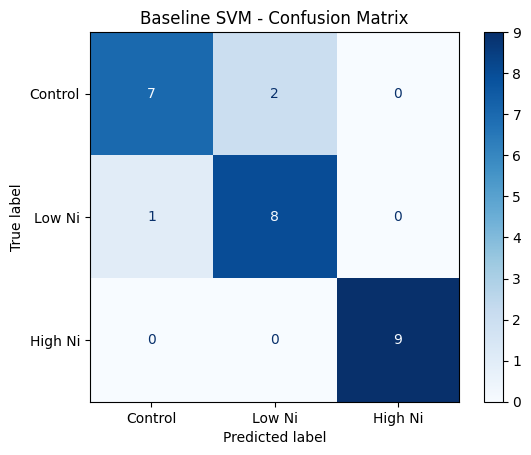

In [ ]:
print("BASELINE SVM MODEL")

# Train baseline SVM with RBF kernel
svm_baseline = SVC(kernel='rbf', random_state=42, class_weight='balanced')
svm_baseline.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = svm_baseline.predict(X_train_scaled)
y_test_pred = svm_baseline.predict(X_test_scaled)

# Evaluate
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nBaseline SVM (RBF kernel) trained")
print(f"  Training accuracy: {train_acc:.4f}")
print(f"  Test accuracy: {test_acc:.4f}")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'Low Ni', 'High Ni']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Low Ni', 'High Ni'])
disp.plot(cmap='Blues')
plt.title('Baseline SVM - Confusion Matrix')
plt.savefig('baseline_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
print("HYPERPARAMETER TUNING")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto'],
    'kernel': ['rbf']
}

print(f"\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV with Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n Grid search completed")
print(f"  Best parameters: {grid_search.best_params_}")
print(f"  Best CV F1-score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
svm_optimized = grid_search.best_estimator_

# Evaluate optimized model
y_train_pred_opt = svm_optimized.predict(X_train_scaled)
y_test_pred_opt = svm_optimized.predict(X_test_scaled)

train_acc_opt = accuracy_score(y_train, y_train_pred_opt)
test_acc_opt = accuracy_score(y_test, y_test_pred_opt)
f1_opt = f1_score(y_test, y_test_pred_opt, average='weighted')

print(f"\n Optimized SVM performance:")
print(f"  Training accuracy: {train_acc_opt:.4f}")
print(f"  Test accuracy: {test_acc_opt:.4f}")
print(f"  Test F1-score (weighted): {f1_opt:.4f}")

print(f"\nClassification Report (Optimized Model - Test Set):")
print(classification_report(y_test, y_test_pred_opt, target_names=['Control', 'Low Ni', 'High Ni']))

HYPERPARAMETER TUNING

Parameter grid:
  C: [0.1, 1, 10, 100]
  gamma: [0.001, 0.01, 0.1, 'scale', 'auto']
  kernel: ['rbf']
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Grid search completed
  Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
  Best CV F1-score: 0.7857

 Optimized SVM performance:
  Training accuracy: 0.8889
  Test accuracy: 0.8519
  Test F1-score (weighted): 0.8500

Classification Report (Optimized Model - Test Set):
              precision    recall  f1-score   support

     Control       0.86      0.67      0.75         9
      Low Ni       0.73      0.89      0.80         9
     High Ni       1.00      1.00      1.00         9

    accuracy                           0.85        27
   macro avg       0.86      0.85      0.85        27
weighted avg       0.86      0.85      0.85        27



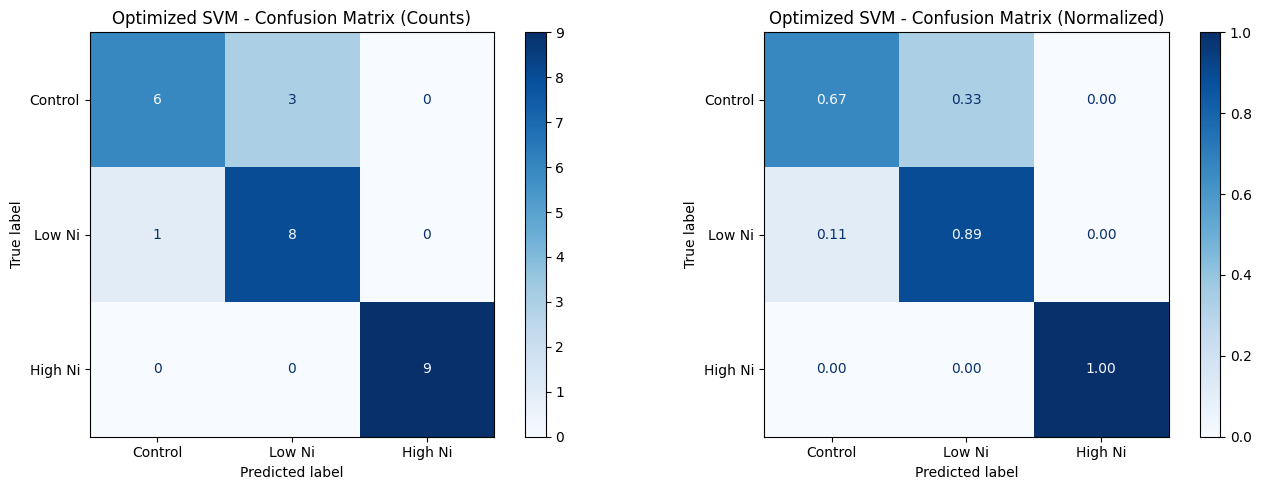


 Cross-validation scores: [0.85714286 0.80952381 0.71428571]
  Mean CV accuracy: 0.7937 (+/- 0.0594)


In [ ]:
# Confusion matrix for optimized model
cm_opt = confusion_matrix(y_test, y_test_pred_opt)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix - counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=['Control', 'Low Ni', 'High Ni'])
disp1.plot(cmap='Blues', ax=axes[0])
axes[0].set_title('Optimized SVM - Confusion Matrix (Counts)')

# Confusion matrix - normalized
cm_opt_norm = cm_opt.astype('float') / cm_opt.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt_norm, display_labels=['Control', 'Low Ni', 'High Ni'])
disp2.plot(cmap='Blues', ax=axes[1], values_format='.2f')
axes[1].set_title('Optimized SVM - Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig('optimized_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


# Cross-validation scores
cv_scores = cross_val_score(svm_optimized, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f"\n Cross-validation scores: {cv_scores}")
print(f"  Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

FEATURE IMPORTANCE ANALYSIS

 Feature importance ranking:
  1. Ni Conc.: 0.1778 (+/- 0.0491)
  2. E-recovery (%): 0.1519 (+/- 0.0387)
  3. Day: 0.0815 (+/- 0.0773)
  4. OD: 0.0815 (+/- 0.0277)
  5. C2 (mg/L): 0.0667 (+/- 0.0222)
  6. pH: 0.0185 (+/- 0.0248)


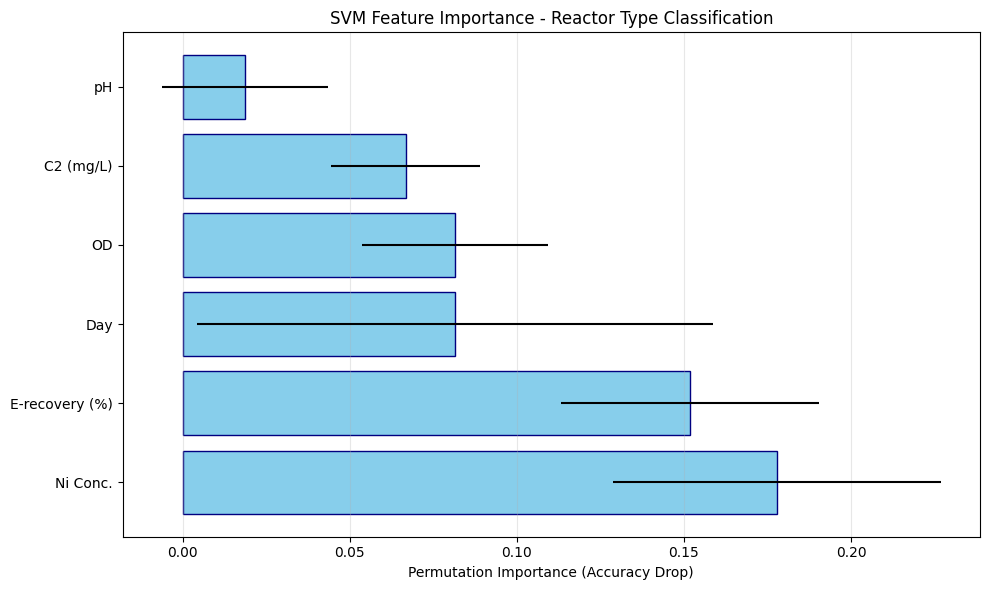

In [ ]:
print("FEATURE IMPORTANCE ANALYSIS")

# Permutation importance
perm_importance = permutation_importance(
    svm_optimized, X_test_scaled, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Get feature names
feature_names = ['C2 (mg/L)', 'E-recovery (%)', 'OD', 'pH', 'Ni Conc.', 'Day']

# Sort features by importance
indices = perm_importance.importances_mean.argsort()[::-1]

print(f"\n Feature importance ranking:")
for i, idx in enumerate(indices, 1):
    print(f"  {i}. {feature_names[idx]}: "
          f"{perm_importance.importances_mean[idx]:.4f} "
          f"(+/- {perm_importance.importances_std[idx]:.4f})")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(indices)), perm_importance.importances_mean[indices],
        xerr=perm_importance.importances_std[indices], color='skyblue', edgecolor='navy')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names[i] for i in indices])
ax.set_xlabel('Permutation Importance (Accuracy Drop)')
ax.set_title('SVM Feature Importance - Reactor Type Classification')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:

print("MODEL INSIGHTS & INTERPRETATION")


# Support vectors analysis
print(f"\n Support Vector Analysis:")
print(f"  Number of support vectors: {svm_optimized.n_support_}")
print(f"  Support vectors per class:")
for i, n_sv in enumerate(svm_optimized.n_support_):
    class_names = ['Control', 'Low Ni', 'High Ni']
    print(f"    {class_names[i]}: {n_sv} support vectors")

# Analyze misclassifications
misclassified_idx = np.where(y_test != y_test_pred_opt)[0]
print(f"\n Misclassification Analysis:")
print(f"  Total misclassified: {len(misclassified_idx)} out of {len(y_test)}")
print(f"  Error rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

if len(misclassified_idx) > 0:
    print(f"\n  Misclassification breakdown:")
    for idx in misclassified_idx[:5]:  # Show first 5
        true_label = ['Control', 'Low Ni', 'High Ni'][y_test[idx]]
        pred_label = ['Control', 'Low Ni', 'High Ni'][y_test_pred_opt[idx]]
        print(f"    True: {true_label}, Predicted: {pred_label}")

# Key findings
print(f"\n KEY FINDINGS:")
print(f"  1. Best kernel: RBF")
print(f"  2. Optimal C: {grid_search.best_params_['C']}")
print(f"  3. Optimal gamma: {grid_search.best_params_['gamma']}")
print(f"  4. Test accuracy: {test_acc_opt:.2%}")
print(f"  5. Most important feature: {feature_names[indices[0]]}")
print(f"  6. Model can distinguish reactor types with {test_acc_opt:.2%} accuracy")

MODEL INSIGHTS & INTERPRETATION

 Support Vector Analysis:
  Number of support vectors: [16 18  6]
  Support vectors per class:
    Control: 16 support vectors
    Low Ni: 18 support vectors
    High Ni: 6 support vectors

 Misclassification Analysis:
  Total misclassified: 4 out of 27
  Error rate: 14.81%

  Misclassification breakdown:
    True: Control, Predicted: Low Ni
    True: Control, Predicted: Low Ni
    True: Low Ni, Predicted: Control
    True: Control, Predicted: Low Ni

 KEY FINDINGS:
  1. Best kernel: RBF
  2. Optimal C: 10
  3. Optimal gamma: 0.1
  4. Test accuracy: 85.19%
  5. Most important feature: Ni Conc.
  6. Model can distinguish reactor types with 85.19% accuracy
